# Machine learning and clustering in Timeflux

In this exercise, we will be using the machine learning node available in Timeflux in order to classify points of a sinus, depending on whether they are a part of the rising or descending phase.

First of all, we are going to write a python script to that will later be integrated into Timeflux

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

from scipy import stats

from sklearn.cluster import KMeans

## 1 - Signal generation

To ensure the robustness of our model, we will train it on a noisy sinus, that we will create right now, using a "random" method.

In [2]:
Fs = 1000 # Signal frequency
f = 5 
sample = 1000 # Number of samples
x_1 = np.arange(sample) 
noise = 0.0008*np.asarray(random.sample(range(0,1000),sample))

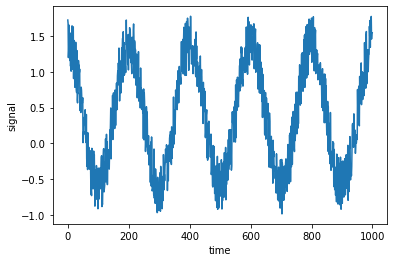

In [3]:
y_1 = np.cos(2 * np.pi * f * x_1 / Fs)+noise #Noisy sinus
plt.plot(x_1, y_1) 
plt.xlabel('time') 
plt.ylabel('signal') 
plt.show()

In [4]:
#Here, we create the true labels of each point
label0 = np.reshape((np.array([[0]*100,[1]*100]*int(sample/200))),-1)

Text(0.5, 1.0, 'Yellow : descending phase, purple : rising phase')

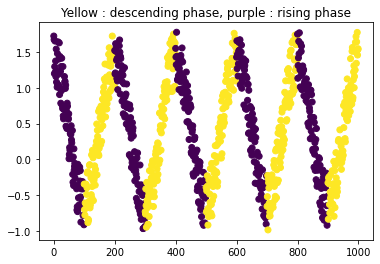

In [5]:
plt.scatter(x_1,y_1, c= label0)
plt.title('Yellow : descending phase, purple : rising phase')

# 2 - Unsupervised clustering

Now that we have the signal, we will use the KMeans algorithm to form clusters according to a single feature : the slope of a sliding window. 

In [6]:
#Sliding windows creation
k = 20 #size of each window
tmp = np.array([y_1]).T
X = [] #
label = []
for ind in range (0, sample-k):
    X.append(tmp[ind:ind+k])
    label.append(label0[ind])
    
window_signal = np.array(X).reshape(-1,k)
window_label = np.array(label)

In [7]:
#We can reshape our signal dataset into a DataFrame in order to make it more clear :
df_window = pd.DataFrame(data = window_signal)

In [8]:
#Before applying KMeans, we will split our dataset into 2 sets, one will train the model, the other one will test it.

X_train, X_test, y_train, y_test = train_test_split(df_window, window_label, test_size = .15)

#### The machine learning node will be using a pipeline. We will begin with an easier one here.
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

The first step of the pipeline will extract the slope of the sliding window. The second one will apply the KMeans algorithm to these slopes, in order to create 2 clusters. We are of course looking to find back the 2 original clusters (rising and descending phases).

In [9]:
from sklearn.pipeline import Pipeline
from utils.estimators import Slope

In [10]:
pipe = Pipeline([
    ("estimator", Slope()),
    ("km", KMeans(n_clusters=2))]) #Creation of the pipeline

In [11]:
train = pipe.fit(X_train.values)
y_pred = pipe.predict(X_test.values)

Now that the model has been trained and tested, we are going to observe it's efficiency thanks to the confusion matrix. It is important to note that the class labeled '0' in the label can be labeled '1' by the KMeans algorithm. So we won't be necessarily looking at the 'up-left to down-right' diagonal to note the score. 

In [12]:
confusion_matrix(y_test, y_pred)

array([[ 7, 63],
       [68,  9]], dtype=int64)

## Integration into Timeflux

Now that we know how to make our pipeline work offline, we need to make it work online.

To do so, you will find in the yaml code 4 subgraphs : 
- Broker, that we explained in the first exercise.
- Generate, that will generate the signal. Noisy sinus is created from the sum of 2 sinuses.
- Plot, that is supposed to print the signal.
- Classify, which uses the machine learning node.



Classify uses different nodes :
- 'window' is used to create sliding windows. 
- 'fit_predict' create the pipeline. 

We create events to communicate with the online script. 
- calibration_starts will be sent to start the accumulation of data.
- calibration_stops will be sent to stop the accumulation of data and train the model on accumulated data. Then, the online test phase will be started.

Once you started executing the classification.yaml script, send these 2 events, waiting a few seconds between each, and print the 'predictions' signal. On it, you'll see printed the predictions from the model. 